In [ ]:
import sys
import os

!pip install rdkit-pypi

In [ ]:
!git clone https://github.com/Romain-MIPI/Reinforcement-Learning-for-De-Novo-Drug-Design.git

In [ ]:
%cd Reinforcement-Learning-for-De-Novo-Drug-Design

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

In [ ]:
from tqdm import tqdm, trange
from rdkit import Chem, DataStructs
from models.rnn_generator import RNNGenerator
from models.generator_data import GeneratorData
from models.utils import canonical_smiles
%matplotlib inline

import seaborn as sns

In [ ]:
from rdkit.Chem import QED

gen_data_path = './data/clean_020724_all_with_update.csv'
data = pd.read_csv(gen_data_path)
smiles = data['SMILES'].values

In [ ]:
from models.utils import get_tokens
my_tokens, _, _ = get_tokens(smiles)
l_tokens = list(my_tokens) + ['<', '>']

In [ ]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[12], keep_header=False, tokens=l_tokens)

In [ ]:
def plot_bar(prediction, n_to_generate):
    value, count = np.unique(prediction, return_counts=True)
    print("Percentage predict class 0 (inactive) :", count[np.where(value==0)]/len(prediction))
    print("Percentage predict class 1 (weakly actif) :", count[np.where(value==1)]/len(prediction))
    print("Percentage predict class 2 (strongly actif) :", count[np.where(value==2)]/len(prediction))
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate, f"({len(prediction)}/{n_to_generate})")
    plt.bar(value, count)
    plt.xlabel('Predicted class')
    plt.ylabel('Number of molecules')
    plt.xticks([0, 1, 2], ['class 0', 'class 1', 'class 2'])
    plt.title('Distribution of predicted class for generated molecules')
    plt.show()

In [ ]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles)

    plot_bar(prediction, n_to_generate)

    return smiles, prediction

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

In [ ]:
hidden_size = 500
stack_width = 500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = RNNGenerator(input_size=gen_data.n_characters, hidden_size=hidden_size,
                             output_size=gen_data.n_characters, layer_type=layer_type,
                             n_layers=1, is_bidirectional=False, has_stack=True,
                             stack_width=stack_width, stack_depth=stack_depth,
                             use_cuda=use_cuda,
                             optimizer_instance=optimizer_instance, lr=lr)

In [ ]:
model_path = './data/checkpoints/generator/checkpoint_stack_rnn'

In [ ]:
# training generative model
# can be skipped if already trained

losses = my_generator.fit(gen_data, 50000)
plt.plot(losses)
my_generator.evaluate(gen_data)
my_generator.save_model(model_path)

In [ ]:
my_generator.load_model(model_path)

In [ ]:
from models.rnn_predictor import RNNPredictor

path_to_params = './data/checkpoints/classification/model_parameters.pkl'
path_to_checkpoint = './data/checkpoints/classification/fold_'

my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, l_tokens)

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

In [ ]:
my_generator_2 = RNNGenerator(input_size=gen_data.n_characters,
                              hidden_size=hidden_size,
                              output_size=gen_data.n_characters,
                              layer_type=layer_type,
                              n_layers=1, is_bidirectional=False, has_stack=True,
                              stack_width=stack_width, stack_depth=stack_depth,
                              use_cuda=use_cuda,
                              optimizer_instance=optimizer_instance, lr=lr)

my_generator_2.load_model(model_path)

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [ ]:
def get_reward_activity(smile, predictor, invalid_reward=0.0):
    _, prediction, invalid_smiles = predictor.predict([smile])
    if len(invalid_smiles) == 1:
        return invalid_reward
    if (prediction[0] == 2):
        return 11.0
    elif (prediction[0] == 1):
        return 6.0
    else:
        return 1.0

In [ ]:
from models.reinforcement import Reinforcement

# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

RL_activity = Reinforcement(my_generator_2, my_predictor, get_reward_activity)

rewards = []
rl_losses = []

for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_activity.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward))
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))

    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()

    smiles_cur, prediction_cur = estimate_and_update(RL_activity.generator,
                                                     my_predictor,
                                                     n_to_generate)

In [ ]:
smiles_biased, prediction_biased = estimate_and_update(RL_activity.generator,
                                                       my_predictor,
                                                       n_to_generate=10000)

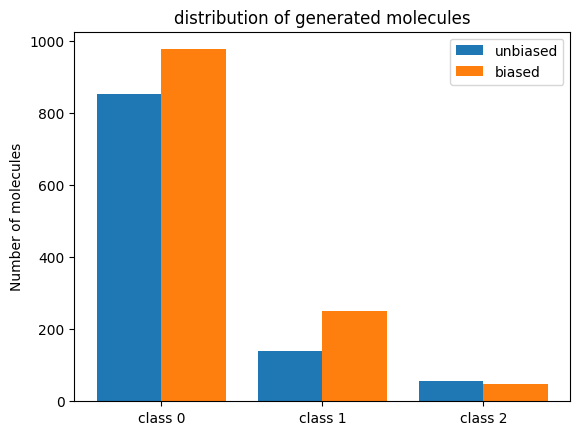

Proportion of valid SMILES unbiased: 0.1047
Proportion of valid SMILES biased: 0.1274


In [ ]:
class_val = [0, 1, 2]

value1, count1 = np.unique(prediction_unbiased, return_counts=True)
value2, count2 = np.unique(prediction_biased, return_counts=True)

if len(value1) != len(class_val):
    tmp = []
    for c in class_val:
        if c not in value1:
            tmp.append(count1[np.where(value1==c)])
        else:
            tmp.append(0)
    count1 = tmp
if len(value2) != len(class_val):
    tmp = []
    for c in class_val:
        if c not in value2:
            tmp.append(count2[np.where(value2==c)])
        else:
            tmp.append(0)
    count2 = tmp

w, x = 0.4, np.arange(len(class_val))

fig, ax = plt.subplots()
ax.bar(x - w/2, count1, width=w, label='unbiased')
ax.bar(x + w/2, count2, width=w, label='biased')

ax.set_xticks(x)
ax.set_xticklabels(['class 0', 'class 1', 'class 2'])
ax.set_ylabel('Number of molecules')
ax.set_title('distribution of generated molecules')
ax.legend()

plt.show()

class0_unbiased = count1[np.where(value1==0)]
class1_unbiased = count1[np.where(value1==1)]
class2_unbiased = count1[np.where(value1==2)]

class0_biased = count2[np.where(value2==0)]
class1_biased = count2[np.where(value2==1)]
class2_biased = count2[np.where(value2==2)]

print("Proportion of valid SMILES unbiased:", len(smiles_unbiased)/10000)
print("Proportion of valid SMILES biased:", len(smiles_biased)/10000)

In [ ]:
gen_data_path = './data/clean_020724_all_with_update.csv'
data = pd.read_csv(gen_data_path)
smiles = data['SMILES'].values
labels = data['Labels'].values

smiles_class_2_unbiased = np.array(smiles_unbiased)[np.where(np.array(prediction_unbiased)==2)]
smiles_class_2_biased = np.array(smiles_biased)[np.where(np.array(prediction_biased)==2)]

unique_smiles_class_2_unbiased = []
for smile in smiles_class_2_unbiased:
    if smile not in smiles:
        unique_smiles_class_2_unbiased.append(smile)

unique_smiles_class_2_biased = []
for smile in smiles_class_2_biased:
    if smile not in smiles:
        unique_smiles_class_2_biased.append(smile)

print(np.array(unique_smiles_class_2_unbiased))
print(np.array(unique_smiles_class_2_biased))

print("proportion of active SMILES unbiased not in database:", len(unique_smiles_class_2_unbiased)/len(smiles_class_2_unbiased))
print("proportion of active SMILES biased not in database:", len(unique_smiles_class_2_biased)/len(smiles_class_2_biased))

In [ ]:
labels_class_2_unbiased = np.array(prediction_unbiased)[np.where(np.array(prediction_unbiased)==2)]
labels_class_2_biased = np.array(prediction_biased)[np.where(np.array(prediction_biased)==2)]

def save_smiles(path, smiles):
    with open(path, 'w') as f:
        for smile in smiles:
            f.write(smile + '\n')

save_smiles('./data/smiles_class_2_unbiased.csv', unique_smiles_class_2_unbiased)
save_smiles('./data/smiles_class_2_biased.csv', unique_smiles_class_2_biased)

In [ ]:
labels = data['Labels'].values

_, predictions, _ = my_predictor.predict(smiles)

count = 0
miss_count = 0

for i in range(len(smiles)):
    if labels[i] != predictions[i]:
        miss_count += 1
        print(f"{miss_count} | {smiles[i]} {labels[i]} {predictions[i]}")
    else:
        count += 1

print(f"accuracy : {(count/len(smiles)*100):.2f}% ({count}/{len(smiles)})")

In [ ]:
from models.smiles_dataset import SmilesDataset
from models.encoder import Encoder
from models.mlp import MLP
from models.smiles2label import Smiles2Label
from models.utils import identity

model_object = Smiles2Label

n_hidden = 128
batch_size = 128
num_epochs = 26
lr = 0.005

model_params = {
    'use_cuda': True,
    'random_seed': 42,
    'world_size': 1,
    'data_layer': SmilesDataset,
    'use_clip_grad': False,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'logdir': './data/checkpoints/classification/',
    'print_every': 1,
    'save_every': 5,
    'train_data_layer': None,
    'val_data_layer': None,
    'eval_metrics': balanced_accuracy_score, # f1_score, recall_score, precision_score
    'average' : "macro",
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': Adam,
    'optimizer_params': {
        'lr': lr,
    },
    'lr_scheduler': ExponentialLR,
    'lr_scheduler_params': {
        'gamma': 0.98
    },
    'embedding': nn.Embedding,
    'embedding_params': {
        'num_embeddings': len(tokens),
        'embedding_dim': n_hidden,
        'padding_idx': tokens.index(' ')
    },
    'encoder': Encoder,
    'encoder_params': {
        'input_size': n_hidden,
        'layer': "LSTM",
        'encoder_dim': n_hidden,
        'n_layers': 2,
        'dropout': 0.8,
        'is_bidirectional': False
    },
    'mlp': MLP,
    'mlp_params': {
        'input_size': n_hidden,
        'n_layers': 2,
        'hidden_size': [n_hidden, 3],
        'activation': [F.relu, identity],
        'dropout': 0.0
    }
}

In [ ]:
from models.smiles2label import evaluate
from models.smiles_dataset import SmilesDataset
from torch.utils.data import DataLoader

metrics = {'bac': balanced_accuracy_score, 'f1': f1_score, 'recall': recall_score, 'precision': precision_score}
rmse = []
score = {'bac':[], 'f1':[], 'recall':[], 'precision':[]}
tmp_data_dir = './data/tmp/'
tokens, _, _ = get_tokens(smiles)
tokens = ''.join(tokens)
criterion = model_params['criterion']
average = model_params['average']

for k, v in metrics.items():
    for i in range(5):
        test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                                    delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                    flip=False)
        test_dataset.target = np.array(test_dataset.target, dtype=np.int64).squeeze()
        val_loader = DataLoader(test_dataset,
                                batch_size=model_params['batch_size'],
                                shuffle=False,
                                num_workers=1,
                                pin_memory=True)

        my_predictor.model[i].eval_metrics = v
        res = evaluate(my_predictor.model[i], val_loader, criterion, average)
        if i == 0:
            rmse.append(np.sqrt(res[0]))
        score[k].append(res[1])

In [ ]:
print("Cross-validated RMSE: ",  np.mean(rmse))

for k, v in metrics.items():
    print(f"Cross-validated {k}: ", np.mean(score[k]))

Cross-validated RMSE:  0.9112761193654249
Cross-validated bac:  0.5672459087186837
Cross-validated f1:  0.5494918434872554
Cross-validated recall:  0.5672459087186837
Cross-validated precision:  0.5533997705667428


In [ ]:
RL_activity.generator.save_model('./data/checkpoints/generator/checkpoint_stack_rnn_biased')